# Tests

In this notebook, we test components needed for making our flow-matching with sine waves work. Specifically

- Generating datasets
- Generating noise
- Localized dataset generation
- Localizing noise for flow-matching

# Imports

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import math

# Importing our existing flow funcs
import os
import sys
from pathlib import Path
parent_dir = Path.cwd()
sys.path.append(str(parent_dir))
# Import modules
from sine_funcs import generate_sine_wave, window_signal, compute_fft
from analytic_flow_funcs import compute_linear_velocity_batch_time

# Set device (automatically detects GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Generating Datasets
The code to verify the generated sine wave is tested in Sine Wave Func tests.

In [2]:
# Function to create a dataset of sine waves of different phases
# Takes in a list of phases, the width of the dataset, and the frequency
# Create a tensor of shape [B, W] where B is number of phases, W is num_points
def create_phase_dataset(phases, num_points=1000, points_per_cycle=40, device = 'cpu'):
    dataset = torch.stack([generate_sine_wave(num_points, points_per_cycle, phase_offset=phase, device = device)
        for phase in phases])
    return dataset

# Parameters with phase offset for demonstration
num_points = 10
points_per_cycle = 10
phases = [0]#, math.pi/4, math.pi/2, 3*math.pi/4]  # Example phase offsets
dataset = create_phase_dataset(phases, num_points, points_per_cycle, device = device)

print(dataset.shape)  # [B, W]

torch.Size([1, 10])


# Generate Noise
Plot the resulting noise sample.

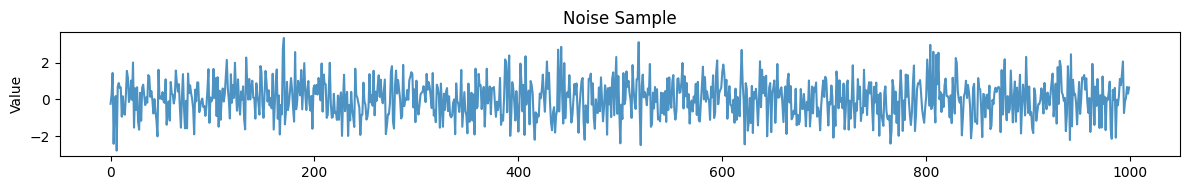

In [3]:
num_points = 1000 #points in a sample
# Generate Gaussian noise with mean 0 and standard deviation 1
noise_sample = torch.randn(size=(num_points, ), device=device)

# Display the first 3 noise samples
plt.figure(figsize=(12, 2))
plt.plot(noise_sample.cpu().numpy(), alpha=0.8)
plt.title(f"Noise Sample")
plt.ylabel("Value")
plt.tight_layout()
plt.show()

# Locality Dataset Testing

Explicitly verify the locality generating functions with a small example.

In [4]:
def window_dataset(dataset, window_size, stride=1):
    """
    Apply windowing to each signal in the dataset and stack results
    Returns tensor of shape [B * num_windows, window_size]
    """
    # Apply unfolding to each batch element
    windows = [signal.unfold(0, window_size, stride) for signal in dataset]
    return torch.cat(windows, dim=0)

num_points = 6
points_per_cycle = 10
phases = [0, math.pi/2]#, math.pi/4, math.pi/2, 3*math.pi/4]  # Example phase offsets
dataset = create_phase_dataset(phases, num_points, points_per_cycle, device = device)
window_size = 3

# Create dataset and apply windowing
windowed_data = window_dataset(dataset, window_size, stride = 1)

print("Original dataset:", dataset)  # [B, W]
print("Windowed data:", windowed_data)  # [B * num_windows, window_size]

print("Original dataset shape:", dataset.shape)  # [B, W]
print("Windowed data shape:", windowed_data.shape)  # [B * num_windows, window_size]

Original dataset: tensor([[ 0.0000e+00,  5.8779e-01,  9.5106e-01,  9.5106e-01,  5.8779e-01,
          1.2246e-16],
        [ 1.0000e+00,  8.0902e-01,  3.0902e-01, -3.0902e-01, -8.0902e-01,
         -1.0000e+00]], dtype=torch.float64)
Windowed data: tensor([[ 0.0000e+00,  5.8779e-01,  9.5106e-01],
        [ 5.8779e-01,  9.5106e-01,  9.5106e-01],
        [ 9.5106e-01,  9.5106e-01,  5.8779e-01],
        [ 9.5106e-01,  5.8779e-01,  1.2246e-16],
        [ 1.0000e+00,  8.0902e-01,  3.0902e-01],
        [ 8.0902e-01,  3.0902e-01, -3.0902e-01],
        [ 3.0902e-01, -3.0902e-01, -8.0902e-01],
        [-3.0902e-01, -8.0902e-01, -1.0000e+00]], dtype=torch.float64)
Original dataset shape: torch.Size([2, 6])
Windowed data shape: torch.Size([8, 3])


# Local Sine Wave Class

A class to quickly generate local sine datasets. Optional printing of tensor sizes.

In [17]:
class Local_Sine_Wave_Denoiser:
    def __init__(self, original_data: torch.Tensor, sigma_i: float, device = "cpu"):
        """
            original_data: Tensor of shape [B, N] where B is batch, N is points
        """
        self.original_data = original_data.clone()
        self.sigma_i = sigma_i
        self.device = device

    def set_time(self, new_time: float) -> None:
        """Set a new time value"""
        self.current_time = new_time
    
    def set_local_windows(self, window_size: int, stride = None) -> torch.Tensor:
        """
        Generates windowed view of the current data
            window_size: Size of each window
            stride: Step between windows (default 1)
        Returns:
            Windowed tensor of shape [B * num_windows, window_size], num_windows = (B - window_size) / stride
        """
        if stride is None:
            stride = 1
        # Apply unfolding to each batch element
        windows = [signal.unfold(0, window_size, stride) 
                  for signal in self.original_data]
        
        self.local_data = torch.cat(windows, dim=0).to(self.device)
        return self.local_data

    def match_to_local(self, current_pts_windowed, print_checks = False) -> torch.Tensor:
        # Takes in a tensor with batches [B, N], where N is the size of local windows
        # Create time tensor matching input batch dimension, generates the flow-matching velocities.
        
        M = current_pts_windowed.shape[0]  # Input batch dimension
        time_tensor = torch.full((M,), self.current_time, device=self.device)
        if (print_checks):
            print("\n=== Tensor Check ===")
            print(f"current_pts_windowed: {current_pts_windowed.device} (shape: {current_pts_windowed.shape})")
            print(f"self.local_data: {self.local_data.device} (shape: {self.local_data.shape})")
            print(f"time_tensor: {time_tensor.device} (shape: {time_tensor.shape})")
            print(f"self.sigma_i: {type(self.sigma_i)} (scalar value: {self.sigma_i})")
            print("===================\n")
            
        # Compute velocity
        velocity = compute_linear_velocity_batch_time(
            current_pts_windowed, 
            self.local_data, 
            time_tensor, 
            self.sigma_i)
        return velocity


Code to test our local sine wave class on a low dimensional example. We explicitly verify the known solution for single step integration, demonstrate the effects of some locality on non-uniform data, and that there is time-dependence in our results.

In [36]:
num_points = 10
dataset = create_phase_dataset(phases = [0], num_points = num_points, points_per_cycle = 10, device = device)
noise_sample = torch.zeros(num_points, device=device)
noise_sample[num_points//2:] = 1
local_denoiser_dataset = Local_Sine_Wave_Denoiser(dataset, sigma_i = 1.0, device=device)
print ("The dataset is \n",dataset)
print ("The noise sample is \n",noise_sample)

## Test at time t = 0 with no locality. The solution here is known.
current_time = 0
current_locality = 10
local_denoiser_dataset.set_time(current_time)
local_windows = local_denoiser_dataset.set_local_windows(current_locality)
windows = noise_sample.unfold(0, current_locality, 1) #unfold our noise 
local_velocities = local_denoiser_dataset.match_to_local(windows, print_checks = True)
print (f"The velocity at time t = {current_time} is:")
print (local_velocities)
## For t = 0 with no locality, the local velocity should take our data directly to an existing noise sample.
print ("Our dataset should be recovered with one step integration here\n")
print (noise_sample + local_velocities)

The dataset is 
 tensor([[ 0.0000e+00,  5.8779e-01,  9.5106e-01,  9.5106e-01,  5.8779e-01,
          1.2246e-16, -5.8779e-01, -9.5106e-01, -9.5106e-01, -5.8779e-01]],
       dtype=torch.float64)
The noise sample is 
 tensor([0., 0., 0., 0., 0., 1., 1., 1., 1., 1.], device='cuda:0')

=== Tensor Check ===
current_pts_windowed: cuda:0 (shape: torch.Size([1, 10]))
self.local_data: cuda:0 (shape: torch.Size([1, 10]))
time_tensor: cuda:0 (shape: torch.Size([1]))
self.sigma_i: <class 'float'> (scalar value: 1.0)

The velocity at time t = 0 is:
tensor([[ 0.0000,  0.5878,  0.9511,  0.9511,  0.5878, -1.0000, -1.5878, -1.9511,
         -1.9511, -1.5878]], device='cuda:0', dtype=torch.float64)
Our dataset should be recovered with one step integration here

tensor([[ 0.0000e+00,  5.8779e-01,  9.5106e-01,  9.5106e-01,  5.8779e-01,
          1.1102e-16, -5.8779e-01, -9.5106e-01, -9.5106e-01, -5.8779e-01]],
       device='cuda:0', dtype=torch.float64)


In [37]:
## Test at time t = 0 with locality. We observe different local velocities here.
current_time = 0
current_locality = 5
local_denoiser_dataset.set_time(current_time)
local_windows = local_denoiser_dataset.set_local_windows(current_locality)
windows = noise_sample.unfold(0, current_locality, 1) #unfold our noise 
local_velocities = local_denoiser_dataset.match_to_local(windows, print_checks = True)
print (f"The local velocities at time t = {current_time} are:")
print (local_velocities)


=== Tensor Check ===
current_pts_windowed: cuda:0 (shape: torch.Size([6, 5]))
self.local_data: cuda:0 (shape: torch.Size([6, 5]))
time_tensor: cuda:0 (shape: torch.Size([6]))
self.sigma_i: <class 'float'> (scalar value: 1.0)

The local velocities at time t = 0 are:
tensor([[ 0.5129,  0.4150,  0.1585, -0.1585, -0.4150],
        [ 0.5129,  0.4150,  0.1585, -0.1585, -1.4150],
        [ 0.5129,  0.4150,  0.1585, -1.1585, -1.4150],
        [ 0.5129,  0.4150, -0.8415, -1.1585, -1.4150],
        [ 0.5129, -0.5850, -0.8415, -1.1585, -1.4150],
        [-0.4871, -0.5850, -0.8415, -1.1585, -1.4150]], device='cuda:0',
       dtype=torch.float64)


In [38]:
## Test at time t = 0.5 with locality.
current_time = 0.5
current_locality = 5
local_denoiser_dataset.set_time(current_time)
local_windows = local_denoiser_dataset.set_local_windows(current_locality)
windows = noise_sample.unfold(0, current_locality, 1) #unfold our noise 
local_velocities = local_denoiser_dataset.match_to_local(windows, print_checks = True)
print (f"The local velocities at time t = {current_time} are:")
print (local_velocities)


=== Tensor Check ===
current_pts_windowed: cuda:0 (shape: torch.Size([6, 5]))
self.local_data: cuda:0 (shape: torch.Size([6, 5]))
time_tensor: cuda:0 (shape: torch.Size([6]))
self.sigma_i: <class 'float'> (scalar value: 1.0)

The local velocities at time t = 0.5 are:
tensor([[ 1.0259,  0.8300,  0.3170, -0.3170, -0.8300],
        [ 0.4310,  1.1852,  1.4867,  1.2204, -1.5121],
        [ 0.1778,  1.2719,  1.8802, -0.2296, -1.0157],
        [ 0.1636,  1.2735, -0.1030, -0.2041, -0.9912],
        [ 0.2951, -0.6472, -0.1062, -0.2886, -1.1247],
        [-1.3512, -0.4451, -0.1329, -0.5339, -1.4949]], device='cuda:0',
       dtype=torch.float64)


# Example Usage

Here, we generate the dataset, the noise samples, load our dataset, and iteratively denoise.

In [103]:
# Dataset generation
num_points = 100 #points in a sample
points_per_cycle = 20
phases = [0]#, math.pi]#/4, math.pi/2, 3*math.pi/4]  # Example phase offsets
dataset = create_phase_dataset(phases, num_points, points_per_cycle, device = device)

# Load our dataset into an instance of local_sine_wave
local_denoiser_dataset = Local_Sine_Wave_Denoiser(dataset, sigma_i = 1.0, device = device)

In [104]:
# Noise Parameters
num_noise_samples = 100  # Number of different noise samples to process
noise_samples = torch.randn(size=(num_noise_samples, num_points), device=device)

In [108]:
# Denoising Parameters
num_steps = 10         # Number of denoising steps
dt = 1.0 / num_steps

# Shape: [num_noise_samples, num_steps+1, num_points]
trajectories = torch.zeros(num_noise_samples, num_steps + 1, num_points, device=device)
trajectories[:, 0] = noise_samples.clone()

locality_sizes = torch.full((num_steps,), 5, device=device) #for each step, use a local window of 100 points.

In [109]:
# Denoising loop for each sample
for sample_idx in range(num_noise_samples):
    current_points = noise_samples[sample_idx].clone()
    
    current_time = 0
    for step in range(1, num_steps + 1):
        # Get current time and locality size
        current_locality = locality_sizes[step - 1]
        local_denoiser_dataset.set_time(current_time)
        local_windows = local_denoiser_dataset.set_local_windows(current_locality)
        
        # Process current noise sample
        windows = current_points.unfold(0, current_locality, 1)
        local_velocities = local_denoiser_dataset.match_to_local(windows)
        
        # Accumulate velocities
        output = torch.zeros(num_points, device=device)
        count = torch.zeros(num_points, device=device)
        
        for i in range(windows.shape[0]):
            start = i
            end = i + current_locality
            output[start:end] += local_velocities[i]
            count[start:end] += 1
        
        net_velocity = output / count
        current_points = current_points + net_velocity * dt
        current_time += dt
        
        # Store in trajectories tensor
        trajectories[sample_idx, step] = current_points.clone()
    if sample_idx%10 == 0:
        print(f"Completed denoising for sample {sample_idx+1}/{num_noise_samples}")

Completed denoising for sample 1/100
Completed denoising for sample 11/100
Completed denoising for sample 21/100
Completed denoising for sample 31/100
Completed denoising for sample 41/100
Completed denoising for sample 51/100
Completed denoising for sample 61/100
Completed denoising for sample 71/100
Completed denoising for sample 81/100
Completed denoising for sample 91/100


# Visualization

Example visualization.

In [113]:
from matplotlib.animation import FuncAnimation

def multi_trajectory_animation(trajectories, interval=100, dataset=None, fig_width=8):
    """Creates vertical animation of 3 denoising trajectories.
    
    Args:
        trajectories: 3D tensor of shape (num_samples, time_steps, signal_length)
        interval: Delay between frames in milliseconds
        dataset: Optional target waveform for comparison
        fig_width: Width of the figure in inches
        
    Returns:
        matplotlib.animation.FuncAnimation object
    """
    # Convert to numpy and adjust dimensions
    if isinstance(trajectories, torch.Tensor):
        trajectories = trajectories.detach().cpu().numpy()
    
    # Transpose to (time_steps, num_samples, signal_length)
    trajectories = np.transpose(trajectories, (1, 0, 2))
    
    # Select first 5 samples (or all if less than 5)
    num_samples = min(5, trajectories.shape[1])
    selected_samples = trajectories[:, :num_samples, :]
    
    # Create figure with vertical subplots
    fig, axes = plt.subplots(num_samples, 1, figsize=(fig_width, 2*num_samples))
    if num_samples == 1:
        axes = [axes]  # Make iterable
    
    # Initialize lines
    lines = []
    for ax, sample_idx in zip(axes, range(num_samples)):
        line, = ax.plot([], [], 'b-', alpha=0.8, label='Denoising')
        lines.append(line)
        ax.set_xlim(0, selected_samples.shape[2])
        ax.set_ylim(selected_samples.min()-0.1, selected_samples.max()+0.1)
        ax.grid(True, alpha=0.3)
        ax.set_ylabel(f"Sample {sample_idx+1}")
        
        # Plot target if provided
        if dataset is not None:
            target = dataset[0].cpu().numpy() if isinstance(dataset, torch.Tensor) else dataset
            ax.plot(target, 'r--', alpha=0.5, label='Dataset Example')
            if sample_idx == 0:
                ax.legend(loc='upper right')
    
    # Set common xlabel at bottom
    axes[-1].set_xlabel("Position")
    
    def update(frame):
        for sample_idx, line in enumerate(lines):
            line.set_data(np.arange(selected_samples.shape[2]), 
                         selected_samples[frame, sample_idx])
        return lines
    
    anim = FuncAnimation(fig, update, frames=selected_samples.shape[0],
                       interval=interval, blit=True)
    plt.close()
    return anim

In [114]:
# After your denoising loop...
anim = multi_trajectory_animation(trajectories, dataset=dataset)

# To display in Jupyter notebook:
from IPython.display import HTML
HTML(anim.to_jshtml())

# Statistics

Code to take the dataset and compute the relevant statistics:
The variance of the power spectrum.
The distribution of phases of the peak.

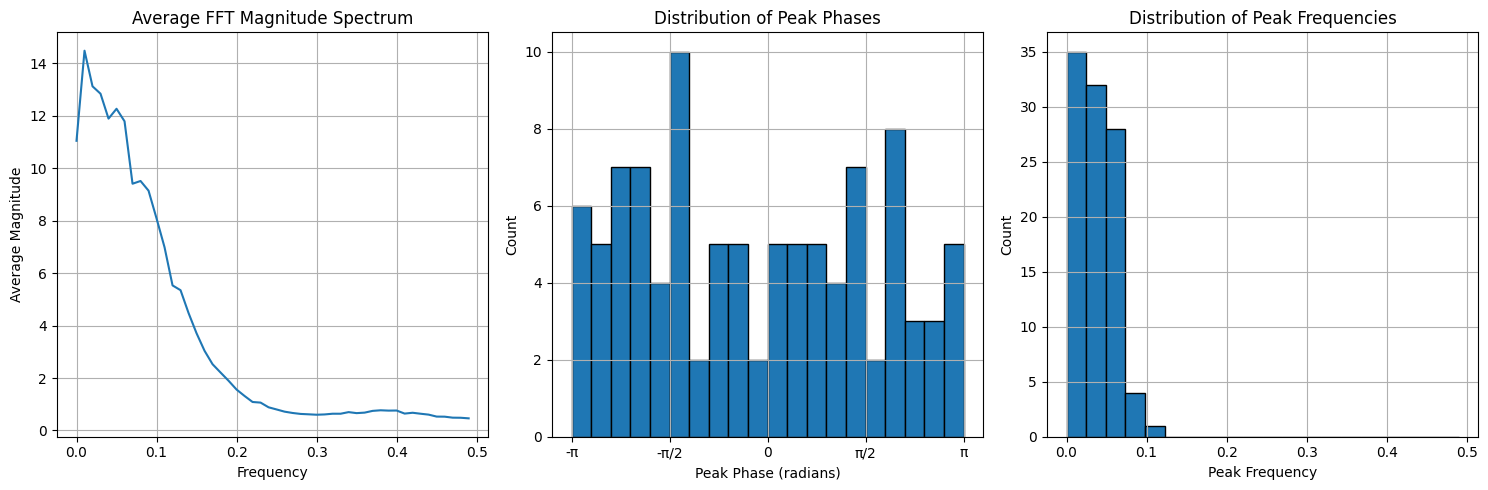

In [112]:
final_waveforms = trajectories[:, -1, :]

num_samples = final_waveforms.shape[0]
signal_length = final_waveforms.shape[1]

# Initialize storage
all_magnitudes = []
peak_phases = []
peak_frequencies = []

# Process each waveform
for waveform in final_waveforms:
    freqs, mag, phase, peak_freq, peak_phase = compute_fft(waveform.cpu())
    all_magnitudes.append(mag)
    peak_phases.append(peak_phase)
    peak_frequencies.append(peak_freq)

# Convert to arrays
all_magnitudes = np.array(all_magnitudes)
peak_phases = np.array(peak_phases)
peak_frequencies = np.array(peak_frequencies)

# Calculate average magnitude spectrum
average_magnitude = np.mean(all_magnitudes, axis=0)

# Create plots
plt.figure(figsize=(15, 5))

# Plot 1: Average magnitude spectrum
plt.subplot(1, 3, 1)
plt.plot(freqs, average_magnitude)
plt.xlabel('Frequency')
plt.ylabel('Average Magnitude')
plt.title('Average FFT Magnitude Spectrum')
plt.grid(True)

# Plot 2: Phase distribution (-π to π)
plt.subplot(1, 3, 2)
plt.hist(peak_phases, bins=20, range=(-np.pi, np.pi), edgecolor='black')
plt.xlabel('Peak Phase (radians)')
plt.ylabel('Count')
plt.title('Distribution of Peak Phases')
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
           ['-π', '-π/2', '0', 'π/2', 'π'])
plt.grid(True)

# Plot 3: Frequency distribution (same x-axis as Plot 1)
plt.subplot(1, 3, 3)
plt.hist(peak_frequencies, bins=20, 
         range=(freqs[0], freqs[-1]),  # Match Plot 1's x-range
         edgecolor='black')
plt.xlabel('Peak Frequency')
plt.ylabel('Count')
plt.title('Distribution of Peak Frequencies')
plt.grid(True)

plt.tight_layout()
plt.show()